Initial Data Overview:
   GridId              Toid  GRID_ExactCut_ID Location_ExactCut  \
0    6256  4000000027865913                27          External   
1    6428  4000000027865913                45          External   
2    6600  4000000027865913                74          External   
3    6772  4000000027865913               106          External   
4    6256  4000000027865914                27          External   

  BoroughName_ExactCut  DoT ID  Length (m) Emissions  Year Pollutant  ...  \
0               NonGLA   16001  117.662736       DFT  2013       CO2  ...   
1               NonGLA   16001  504.845737       DFT  2013       CO2  ...   
2               NonGLA   16001  511.909513       DFT  2013       CO2  ...   
3               NonGLA   16001   51.510888       DFT  2013       CO2  ...   
4               NonGLA   16001  114.435065       DFT  2013       CO2  ...   

   Diesel Car  Electric Car  Petrol LGV  Diesel LGV  Electric LGV    TfL Bus  \
0  160.672802           0.0    

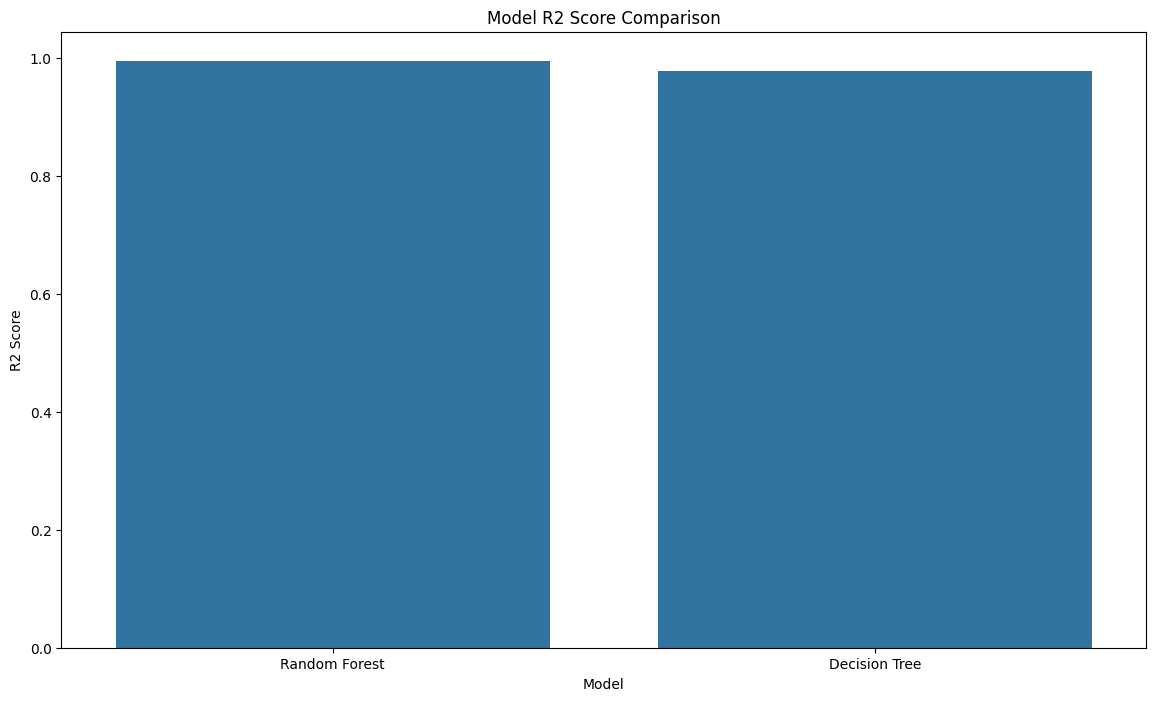

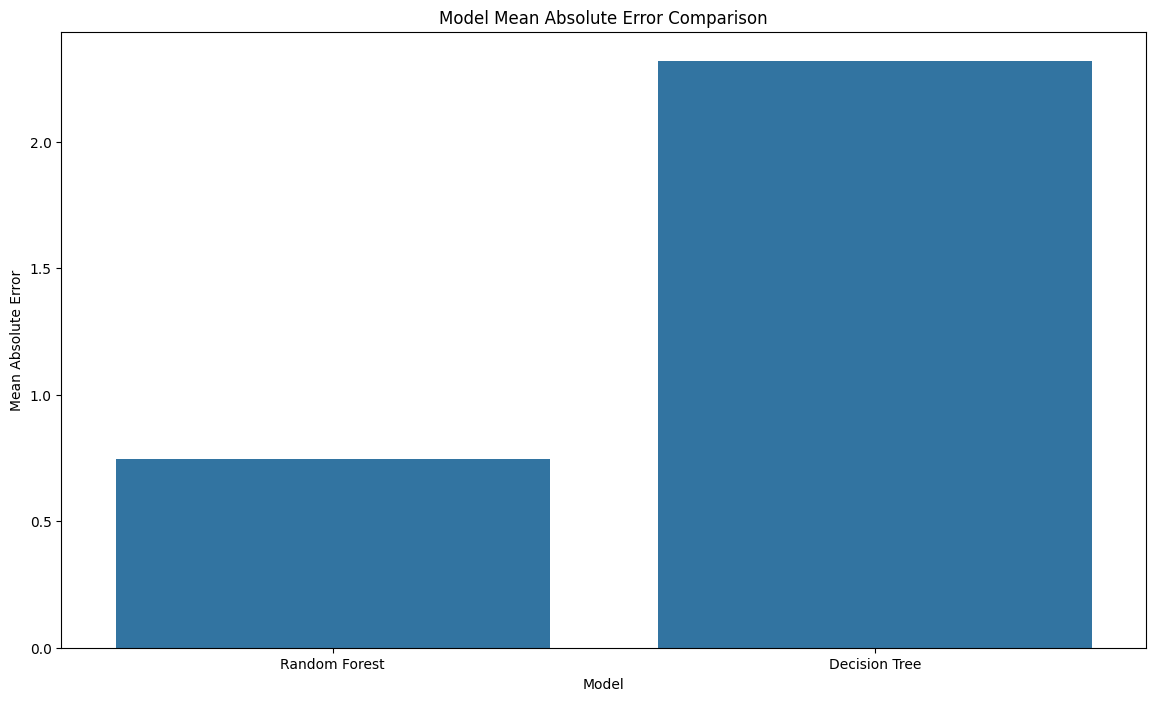

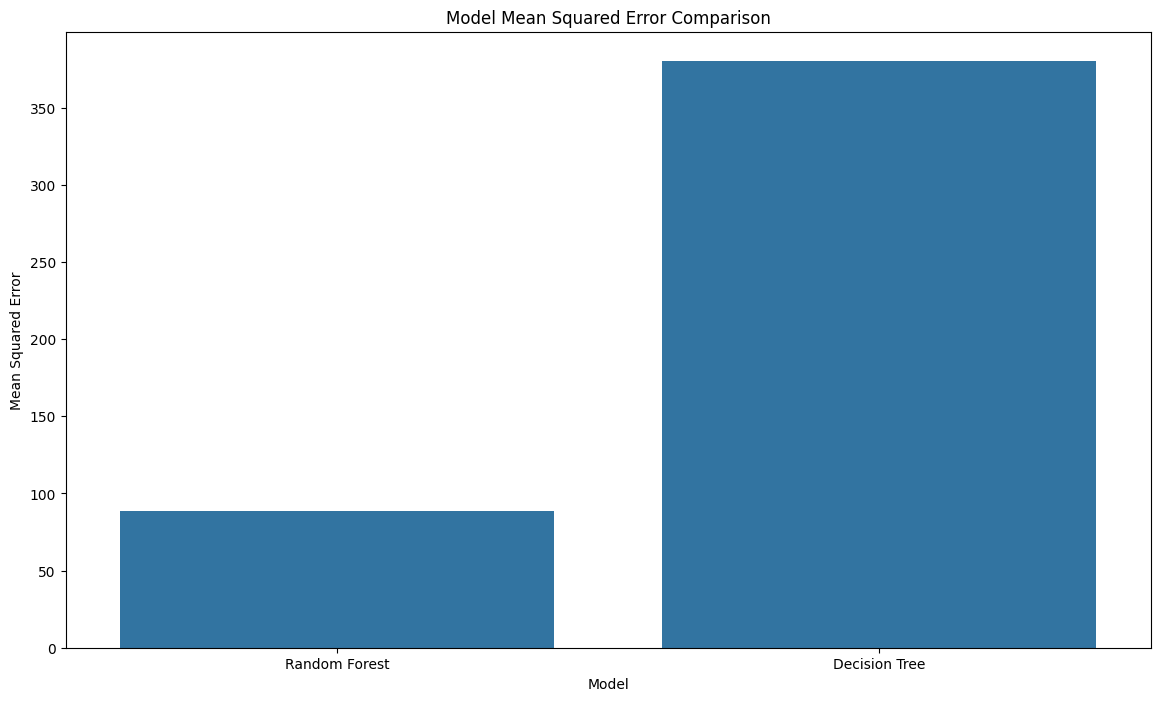

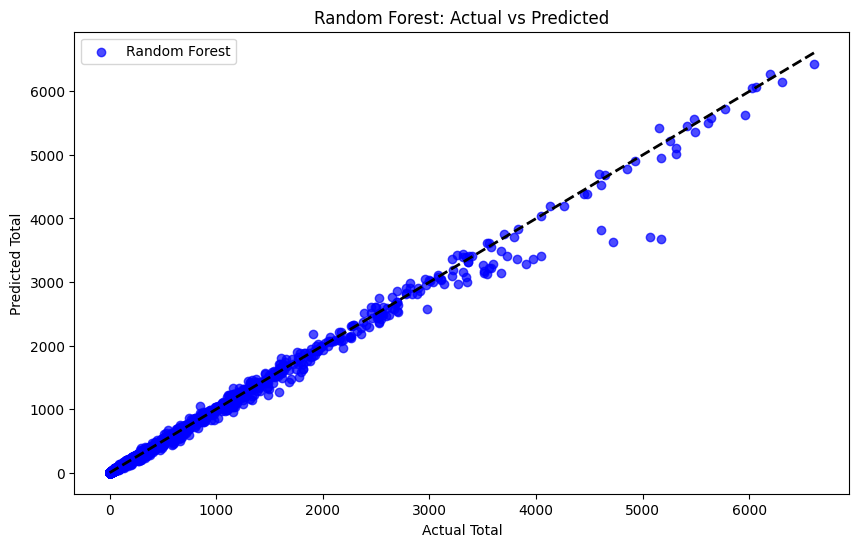

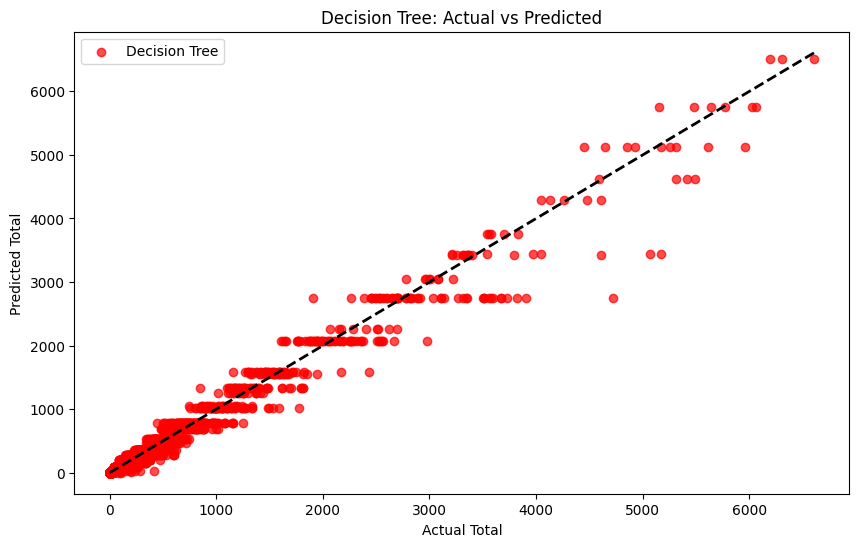


Random Forest predictions saved to Random_Forest_predictions_with_pollutant_names.csv

Decision Tree predictions saved to Decision_Tree_predictions_with_pollutant_names.csv


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load and Inspect the Data
data = pd.read_excel("/content/drive/MyDrive/dissertation_data/modified_2013_data.xlsx")
print("Initial Data Overview:")
print(data.head())
print(data.info())

# Step 2: Preprocessing
# Handle missing values
for column in data.columns:
    if data[column].dtype == 'object':  # Categorical columns
        data[column].fillna(data[column].mode()[0], inplace=True)
    else:  # Numerical columns
        data[column].fillna(data[column].mean(), inplace=True)

data['Year'] = data['Year'].astype(int)  # Ensure 'Year' is integer

# Step 3: Define Features and Target
X = data.drop(columns=['Total'])
y = data['Total']  # Target variable

categorical_features = ['Pollutant', 'Emissions Unit', 'BoroughName_ExactCut']
numerical_features = ['Year', 'Motorcycle', 'Taxi', 'Petrol Car', 'Diesel Car',
                      'Electric Car', 'Petrol LGV', 'Diesel LGV', 'Electric LGV',
                      'TfL Bus', 'Coach', 'Rigid HGV', 'Artic HGV']

# Step 4: Column Transformer and Pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),  # Scale numerical features
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)  # One-hot encode categorical features
    ])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define Random Forest model pipeline
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(random_state=42))
])

# Define a more focused parameter grid for Random Forest
rf_param_grid = {
    'model__n_estimators': [50],  # Reduced number of trees for quicker training
    'model__max_depth': [10],  # Simpler depth options
    'model__min_samples_split': [2],  # Fewer split options
    'model__min_samples_leaf': [1],  # Simpler leaf settings
}

# Use RandomizedSearchCV with fewer iterations
rf_random_search = RandomizedSearchCV(
    rf_pipeline, rf_param_grid, n_iter=1, cv=2, scoring='r2', n_jobs=-1, verbose=2, random_state=42
)

# Train the Random Forest model
print("\nTraining Random Forest...")
rf_random_search.fit(X_train, y_train)
print("Training completed for Random Forest.")

# Best Random Forest model
rf_best_model = rf_random_search.best_estimator_
print(f"Best Random Forest Parameters: {rf_random_search.best_params_}")

# Make predictions with Random Forest
rf_predictions = rf_best_model.predict(X_test)

# Evaluation Metrics for Random Forest
rf_mse = mean_squared_error(y_test, rf_predictions)
rf_mae = mean_absolute_error(y_test, rf_predictions)
rf_r2 = r2_score(y_test, rf_predictions)

# Define Decision Tree model pipeline
dt_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', DecisionTreeRegressor(random_state=42))
])

# Define a more focused parameter grid for Decision Tree
dt_param_grid = {
    'model__max_depth': [5],  # Reduced depth options for quicker training
    'model__min_samples_split': [2],  # Fewer split options
    'model__min_samples_leaf': [1],  # Simpler leaf settings
}

# Use RandomizedSearchCV with fewer iterations
dt_random_search = RandomizedSearchCV(
    dt_pipeline, dt_param_grid, n_iter=1, cv=2, scoring='r2', n_jobs=-1, verbose=2, random_state=42
)

# Train the Decision Tree model
print("\nTraining Decision Tree...")
dt_random_search.fit(X_train, y_train)
print("Training completed for Decision Tree.")

# Best Decision Tree model
dt_best_model = dt_random_search.best_estimator_
print(f"Best Decision Tree Parameters: {dt_random_search.best_params_}")

# Make predictions with Decision Tree
dt_predictions = dt_best_model.predict(X_test)

# Evaluation Metrics for Decision Tree
dt_mse = mean_squared_error(y_test, dt_predictions)
dt_mae = mean_absolute_error(y_test, dt_predictions)
dt_r2 = r2_score(y_test, dt_predictions)

# Step 6: Visualization of Model Evaluation Results
results_df = pd.DataFrame({
    'Mean Squared Error': [rf_mse, dt_mse],
    'Mean Absolute Error': [rf_mae, dt_mae],
    'R2 Score': [rf_r2, dt_r2]
}, index=['Random Forest', 'Decision Tree'])

print("\nModel Comparison Results:")
print(results_df)

# Plotting R2 Score
plt.figure(figsize=(14, 8))
sns.barplot(x=results_df.index, y='R2 Score', data=results_df)
plt.title('Model R2 Score Comparison')
plt.ylabel('R2 Score')
plt.xlabel('Model')
plt.show()

# Plotting Mean Absolute Error
plt.figure(figsize=(14, 8))
sns.barplot(x=results_df.index, y='Mean Absolute Error', data=results_df)
plt.title('Model Mean Absolute Error Comparison')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Model')
plt.show()

# Plotting Mean Squared Error
plt.figure(figsize=(14, 8))
sns.barplot(x=results_df.index, y='Mean Squared Error', data=results_df)
plt.title('Model Mean Squared Error Comparison')
plt.ylabel('Mean Squared Error')
plt.xlabel('Model')
plt.show()

# Plot Actual vs Predicted for Random Forest
plt.figure(figsize=(10, 6))
plt.scatter(y_test, rf_predictions, alpha=0.7, label='Random Forest', color='blue')
plt.xlabel('Actual Total')
plt.ylabel('Predicted Total')
plt.title('Random Forest: Actual vs Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.legend()
plt.show()

# Plot Actual vs Predicted for Decision Tree
plt.figure(figsize=(10, 6))
plt.scatter(y_test, dt_predictions, alpha=0.7, label='Decision Tree', color='red')
plt.xlabel('Actual Total')
plt.ylabel('Predicted Total')
plt.title('Decision Tree: Actual vs Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.legend()
plt.show()

# Save predictions to CSV
results_with_pollutant_rf = X_test.copy()
results_with_pollutant_rf['Actual_Total'] = y_test
results_with_pollutant_rf['Predicted_Total'] = rf_predictions
results_with_pollutant_rf.to_csv('Random_Forest_predictions_with_pollutant_names.csv', index=False)
print("\nRandom Forest predictions saved to Random_Forest_predictions_with_pollutant_names.csv")

results_with_pollutant_dt = X_test.copy()
results_with_pollutant_dt['Actual_Total'] = y_test
results_with_pollutant_dt['Predicted_Total'] = dt_predictions
results_with_pollutant_dt.to_csv('Decision_Tree_predictions_with_pollutant_names.csv', index=False)
print("\nDecision Tree predictions saved to Decision_Tree_predictions_with_pollutant_names.csv")
